# {Metric name}
- Write the name of the metric or the name of a group of metrics that will be implemented in this notebook.

## Description:
The desciption of the metrics should explain their definition and purpose. It can include the following points:

    - A list of all the metrics implemented in this notebook.
    - What are these metrics calculating? and how?
    - How to interpret the metrics? 
    - Link to the ocp-ci-analysis repository issue.
    - Additional notes and information.
    


# Example: _Flake metrics_

_One of the key perfomance indicators that we would like to create greater visbility into and track over time is overall number and percent of flakes that occur. Individual test runs are flagged a "flake" if they are run mulitple times with a mix of passes and failes without any changes to the code being tested. Although they occur for individual test runs, there are a number of aggregate views that developers may want to look at to assess the overall health of their project or testing platform. Through this notebook, we will be able to compute:_
* Percentage of flakes on platform each day
* Percentage of flakes by tab each week
* Percentage of flakes by grid each month
* Percentage of flakes by test overall (this can also be seen as a severity level = overall flake rate of test)
* Severity of flakes

_In order to provide maximum flexibility for the end-user of this work, instead of creating a number of dataframes to answer each of these specifc questions, we will define a long and narrow data structure (a list of tuples saved as a csv for now) that contains only 5 columns ("timestamp", "tab","grid","test","flake"). This allows superset (or pandas) to perform the last filter and/or aggreagtion of interest to an end user. Which is to say, there may appear to be a lot of repetion within the final dataset, but each row should be unique, and it should provide the simpelest useability for an end-user._  

_Linked issues: [Issue 1](https://github.com/aicoe-aiops/ocp-ci-analysis/issues/104), [Issue 2](https://github.com/aicoe-aiops/ocp-ci-analysis/issues/138)_

In [1]:
## Import libraries
from enum import Enum
import pandas as pd
import numpy as np
import datetime
import os
from io import BytesIO
import gzip
import json
import matplotlib.pyplot as plt
from dotenv import load_dotenv, find_dotenv
import boto3

load_dotenv(find_dotenv())

True

In [2]:
## Specify variables

# Specify the path for input grid data
INPUT_DATA_PATH = "../../../../data/raw/testgrid_810.json.gz"

# Specify the path for output metric data
OUTPUT_DATA_PATH = "../../../../data/processed/metrics/"

## CEPH Bucket variables
## Create a .env file on your local with the correct configs
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")
s3_path = os.getenv("S3_PROJECT_KEY")

In [3]:
## Import data
with gzip.open(INPUT_DATA_PATH, "rb") as read_file:
    testgrid_data = json.load(read_file)

In [4]:
## Helper classes and functions
## In your metric notebook, you could just
## load the template notebook functions
## If your metric requires specific helper
## functions, write them here, otherwise if these
## functions are general, update the template.


class TestStatus(Enum):
    """
    Enum to encode what test status each value in testgrid corresponds to

    Basically python equivalent of the enum here:
    https://github.com/GoogleCloudPlatform/testgrid/blob/a18fe953cf98174c215c43e0258b0515e37c283b/pb/test_status/test_status.proto#L3
    """

    NO_RESULT = 0
    PASS = 1
    PASS_WITH_ERRORS = 2
    PASS_WITH_SKIPS = 3
    RUNNING = 4
    CATEGORIZED_ABORT = 5
    UNKNOWN = 6
    CANCEL = 7
    BLOCKED = 8
    TIMED_OUT = 9
    CATEGORIZED_FAIL = 10
    BUILD_FAIL = 11
    FAIL = 12
    FLAKY = 13
    TOOL_FAIL = 14
    BUILD_PASSED = 15


def decode_run_length(x):
    """
    Decodes the run length encoded data into an unrolled form.
    Returns a list of values.

    E.g. takes in [{"value":12, "count":3}, {"value":1, "count":2}]
    and gives [12, 12, 12, 1, 1]
    """
    lst = []
    for run_length in x:
        extension = [run_length["value"]] * run_length["count"]
        lst.extend(extension)
    return lst


def testgrid_labelwise_encoding(data, label):
    """
    Run length encode the dataset and unroll the dataset into a list.
    Return flattened list after encoding specified value as
    True and rest as False
    """

    percent_label_by_grid_csv = []

    for tab in data.keys():

        for grid in data[tab].keys():
            current_grid = data[tab][grid]
            if len(current_grid["grid"]) == 0:
                pass
            else:
                # get all timestamps for this grid (x-axis of grid)
                timestamps = [
                    datetime.datetime.fromtimestamp(x // 1000)
                    for x in current_grid["timestamps"]
                ]
                # get all test names for this grid (y-axis of grid)
                tests = [
                    current_grid["grid"][i]["name"]
                    for i in range(len(current_grid["grid"]))
                ]
                # unroll the run-length encoding and set bool for flake or not (x==13)
                decoded = [
                    (
                        np.array(decode_run_length(current_grid["grid"][i]["statuses"]))
                        == label
                    ).tolist()
                    for i in range(len(current_grid["grid"]))
                ]
                # add the timestamp to bool value
                decoded = [list(zip(timestamps, g)) for g in decoded]
                # add the test, tab and grid name to each entry
                # TODO: any ideas for avoiding this quad-loop
                for i, d in enumerate(decoded):
                    for j, k in enumerate(d):
                        decoded[i][j] = (k[0], tab, grid, tests[i], k[1])
                # accumulate the results
                percent_label_by_grid_csv.append(decoded)

    # output above leaves us with a doubly nested list. Flatten
    flat_list = [item for sublist in percent_label_by_grid_csv for item in sublist]
    flatter_list = [item for sublist in flat_list for item in sublist]

    return flatter_list

## Calculation
- In this section, calculate the metric values from the data.
- For example, we shall use flake metrics calculation.

In [5]:
unrolled_list = testgrid_labelwise_encoding(testgrid_data, 13)
print(len(unrolled_list))

19483548


In [6]:
# Next, print the data frame head with the metric values.
df = pd.DataFrame(unrolled_list, columns=["timestamp", "tab", "grid", "test", "flake"])
df.head()

,timestamp,tab,grid,test,flake
0,2020-10-08 20:48:05,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,Application behind service load balancer with ...,False
1,2020-10-08 19:12:01,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,Application behind service load balancer with ...,False
2,2020-10-08 14:18:13,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,Application behind service load balancer with ...,False
3,2020-10-08 11:15:28,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,Application behind service load balancer with ...,False
4,2020-10-08 08:27:53,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,Application behind service load balancer with ...,False


In [7]:
## Calculate flake severity or flake rate by tests
## Moving forward, this will be aggregated in Superset
## For the sake of completeness, it is implmented here
flake_severity = df.groupby("test").flake.mean().reset_index()
flake_severity.rename(columns={"flake": "flake_severity"}, inplace=True)
flake_severity

,test,flake_severity
0,Add Secret to Workloads.Add Secret to Workload...,0.0
1,Add Secret to Workloads.Add Secret to Workload...,0.0
2,Alertmanager: Configuration.creates PagerDuty ...,0.0
3,Alertmanager: Configuration.creates a receiver...,0.0
4,Alertmanager: Configuration.deletes PagerDuty ...,0.0
...,...,...
7793,user.openshift.io~v1~Group.Kubernetes resource...,0.0
7794,user.openshift.io~v1~Group.Kubernetes resource...,0.0
7795,user.openshift.io~v1~Group.Kubernetes resource...,0.0
7796,user.openshift.io~v1~Group.Kubernetes resource...,0.0


## Visualization 
- In this optional section, you can provide a quick visualization of the metric that you computed.
- Although, the main visualization will be done in Superset, the graphs helps to understand the metric better.
- The following plot shows the flake severity metric for a snapshot of the data.

<Figure size 1080x720 with 0 Axes>

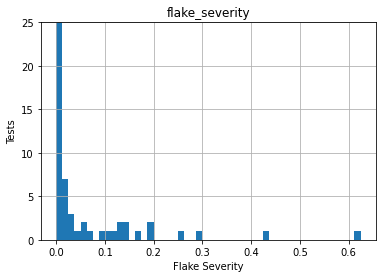

In [8]:
plt.figure(figsize=((15, 10)))
flake_severity.hist(bins=50)
plt.ylabel("Tests")
plt.xlabel("Flake Severity")
plt.ylim((0, 25))
plt.show()

### Save to Ceph
* Use the following helper function to save the data frame in a parquet format on the Ceph bucket

In [9]:
def upload_to_ceph(dataframe, filename):
    """
    This helper function takes as input the data frame to be uploaded, and the output filename.
    It then saves the data frame in the defined ceph bucket.
    """
    parquet_buffer = BytesIO()
    dataframe.to_parquet(parquet_buffer)
    s3_resource = boto3.resource(
        "s3",
        endpoint_url=s3_endpoint_url,
        aws_access_key_id=s3_access_key,
        aws_secret_access_key=s3_secret_key,
    )
    s3_obj = s3_resource.Object(s3_bucket, f"{s3_path}/{filename}")
    status = s3_obj.put(Body=parquet_buffer.getvalue())
    return status


def read_from_ceph(key):
    """
    Helper function to read from ceph and see if the saved data is correct.
    """
    buffer = BytesIO()
    s3 = boto3.resource(
        "s3",
        endpoint_url=s3_endpoint_url,
        aws_access_key_id=s3_access_key,
        aws_secret_access_key=s3_secret_key,
    )

    s3_object = s3.Object(s3_bucket, f"{s3_path}/{key}")
    s3_object.download_fileobj(buffer)
    df_temp = pd.read_parquet(buffer)
    return df_temp

In [10]:
upload_to_ceph(df, "flake_severity/flake.parquet")

{'ResponseMetadata': {'RequestId': 'kmdvrioj-5xh3ql-1e2x',
  'HostId': 'kmdvrioj-5xh3ql-1e2x',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-request-id': 'kmdvrioj-5xh3ql-1e2x',
   'x-amz-id-2': 'kmdvrioj-5xh3ql-1e2x',
   'access-control-allow-origin': '*',
   'access-control-allow-credentials': 'true',
   'access-control-allow-methods': 'GET,POST,PUT,DELETE,OPTIONS',
   'access-control-allow-headers': 'Content-Type,Content-MD5,Authorization,X-Amz-User-Agent,X-Amz-Date,ETag,X-Amz-Content-Sha256',
   'access-control-expose-headers': 'ETag,X-Amz-Version-Id',
   'etag': '"1c10ff80de3690398700987f9add64d4"',
   'date': 'Wed, 17 Mar 2021 20:11:47 GMT',
   'content-length': '0',
   'set-cookie': '1a4aa612fe797ac8466d7ee00e5520d5=9fe18d066a3948e2fb125672aec1d05d; path=/; HttpOnly; Secure; SameSite=None'},
  'RetryAttempts': 0},
 'ETag': '"1c10ff80de3690398700987f9add64d4"'}

In [11]:
## Sanity check to see if the dataset is the same
read_from_ceph("flake_severity/flake.parquet")

,timestamp,tab,grid,test,flake
0,2020-10-08 20:48:05,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,Application behind service load balancer with ...,False
1,2020-10-08 19:12:01,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,Application behind service load balancer with ...,False
2,2020-10-08 14:18:13,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,Application behind service load balancer with ...,False
3,2020-10-08 11:15:28,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,Application behind service load balancer with ...,False
4,2020-10-08 08:27:53,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,Application behind service load balancer with ...,False
...,...,...,...,...,...
19483543,2020-09-25 08:01:10,"""redhat-osde2e-stage-moa""",osde2e-stage-moa-e2e-upgrade-default-next,Overall,False
19483544,2020-09-25 00:01:27,"""redhat-osde2e-stage-moa""",osde2e-stage-moa-e2e-upgrade-default-next,Overall,False
19483545,2020-09-24 16:00:30,"""redhat-osde2e-stage-moa""",osde2e-stage-moa-e2e-upgrade-default-next,Overall,False
19483546,2020-09-24 08:00:46,"""redhat-osde2e-stage-moa""",osde2e-stage-moa-e2e-upgrade-default-next,Overall,False


### Save to disk
* Use the following helper function to save the data frame in the parquet format on the disk

In [12]:
def save_to_disk(dataframe, filename):
    """
    Helper function to save the dataframe
    as a parquet file to disk.
    """
    dataframe.to_parquet(f"{OUTPUT_DATA_PATH}/{filename}")
    return True


def read_from_disk(filename):
    """
    Helper function to read from disk and see if the saved data is the same.
    """
    return pd.read_parquet(f"{OUTPUT_DATA_PATH}/{filename}")

In [13]:
save_to_disk(df, "flake.parquet")

True

In [14]:
## Sanity check to see if the dataset is the same
read_from_disk("flake.parquet")

,timestamp,tab,grid,test,flake
0,2020-10-08 20:48:05,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,Application behind service load balancer with ...,False
1,2020-10-08 19:12:01,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,Application behind service load balancer with ...,False
2,2020-10-08 14:18:13,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,Application behind service load balancer with ...,False
3,2020-10-08 11:15:28,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,Application behind service load balancer with ...,False
4,2020-10-08 08:27:53,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,Application behind service load balancer with ...,False
...,...,...,...,...,...
19483543,2020-09-25 08:01:10,"""redhat-osde2e-stage-moa""",osde2e-stage-moa-e2e-upgrade-default-next,Overall,False
19483544,2020-09-25 00:01:27,"""redhat-osde2e-stage-moa""",osde2e-stage-moa-e2e-upgrade-default-next,Overall,False
19483545,2020-09-24 16:00:30,"""redhat-osde2e-stage-moa""",osde2e-stage-moa-e2e-upgrade-default-next,Overall,False
19483546,2020-09-24 08:00:46,"""redhat-osde2e-stage-moa""",osde2e-stage-moa-e2e-upgrade-default-next,Overall,False


### Conclusion
- Report the status of the calculation that you aimed to complete in this notebook.
- Highlight any difficulties in the calculation of the metric.
- Optional: Add any side notes, future efforts

### _Example Conclusion_ 
_This notebook computed number of flakes and the flake severity metric. The dataframe saved on ceph can be used to generate aggregated views and visualizations._